In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Qp-fhNDzggoyCg-p24QGIgY5uMUnzcznMxwMSUevt6nN',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'flightdelaymodeldeployment-donotdelete-pr-4kibuoqvni4qoz'
object_key = 'FLIGHTDELAYDATA.CSV'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dataset = pd.read_csv(body)
dataset.head()


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,0.0,2143,2102.0,-41.0,0.0,0,0,338,295.0,2182
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,0.0,1435,1439.0,4.0,0.0,0,0,110,115.0,528
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,0.0,1215,1142.0,-33.0,0.0,0,0,335,300.0,2182
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,0.0,1335,1345.0,10.0,0.0,0,0,196,205.0,1399
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,0.0,607,615.0,8.0,0.0,0,0,247,259.0,1927


In [3]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [5]:
dataset.describe()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,...,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
count,11231.0,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11124.000000,...,11124.000000,11231.000000,11116.000000,11043.000000,11043.000000,11231.000000,11231.000000,11231.000000,11043.000000,11231.000000
mean,2016.0,2.544475,6.628973,15.790758,3.960199,1334.325617,12334.516695,12302.274508,1320.798326,1327.189410,...,0.142844,1537.312795,1523.978499,-2.573123,0.124513,0.010150,0.006589,190.652124,179.661233,1161.031965
std,0.0,1.090701,3.354678,8.782056,1.995257,811.875227,1595.026510,1601.988550,490.737845,500.306462,...,0.349930,502.512494,512.536041,39.232521,0.330181,0.100241,0.080908,78.386317,77.940399,643.683379
min,2016.0,1.000000,1.000000,1.000000,1.000000,7.000000,10397.000000,10397.000000,10.000000,1.000000,...,0.000000,2.000000,1.000000,-67.000000,0.000000,0.000000,0.000000,93.000000,75.000000,509.000000
25%,2016.0,2.000000,4.000000,8.000000,2.000000,624.000000,10397.000000,10397.000000,905.000000,905.000000,...,0.000000,1130.000000,1135.000000,-19.000000,0.000000,0.000000,0.000000,127.000000,117.000000,594.000000
50%,2016.0,3.000000,7.000000,16.000000,4.000000,1267.000000,12478.000000,12478.000000,1320.000000,1324.000000,...,0.000000,1559.000000,1547.000000,-10.000000,0.000000,0.000000,0.000000,159.000000,149.000000,907.000000
75%,2016.0,3.000000,9.000000,23.000000,6.000000,2032.000000,13487.000000,13487.000000,1735.000000,1739.000000,...,0.000000,1952.000000,1945.000000,1.000000,0.000000,0.000000,0.000000,255.000000,236.000000,1927.000000
max,2016.0,4.000000,12.000000,31.000000,7.000000,2853.000000,14747.000000,14747.000000,2359.000000,2400.000000,...,1.000000,2359.000000,2400.000000,615.000000,1.000000,1.000000,1.000000,397.000000,428.000000,2422.000000


In [6]:
dataset.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [7]:
dataset['DEST'].unique()

array(['SEA', 'MSP', 'DTW', 'ATL', 'JFK'], dtype=object)

<AxesSubplot:>

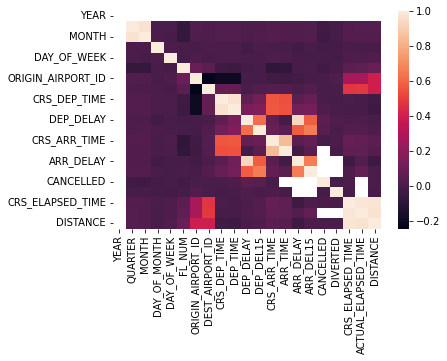

In [8]:
sns.heatmap(dataset.corr())

In [9]:
dataset=dataset[["FL_NUM","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","ORIGIN","DEST","CRS_ARR_TIME","DEP_DEL15","ARR_DEL15"]]
dataset.isnull().sum()

FL_NUM            0
MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_ARR_TIME      0
DEP_DEL15       107
ARR_DEL15       188
dtype: int64

In [10]:
dataset = dataset.fillna({'ARR_DEL15':1})
dataset =dataset.fillna({'DEP_DEL15':0})
dataset.iloc[177:185]

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,0.0,1.0
178,2839,1,9,6,DTW,JFK,1724,0.0,0.0
179,86,1,10,7,MSP,DTW,1632,0.0,1.0
180,87,1,10,7,DTW,MSP,1649,1.0,0.0
181,423,1,10,7,JFK,ATL,1600,0.0,0.0
182,440,1,10,7,JFK,ATL,849,0.0,0.0
183,485,1,10,7,JFK,SEA,1945,1.0,0.0
184,557,1,10,7,MSP,DTW,912,0.0,1.0


In [11]:
import math
for index,row in dataset.iterrows():
  dataset.loc[index,'CRS_ARR_TIME'] = math.floor(row['CRS_ARR_TIME'])
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,ATL,SEA,2143,0.0,0.0
1,1476,1,1,5,DTW,MSP,1435,0.0,0.0
2,1597,1,1,5,ATL,SEA,1215,0.0,0.0
3,1768,1,1,5,SEA,MSP,1335,0.0,0.0
4,1823,1,1,5,SEA,DTW,607,0.0,0.0


In [12]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
dataset['DEST']=le.fit_transform(dataset['DEST'])
dataset['ORIGIN']=le.fit_transform(dataset['ORIGIN'])

In [13]:
dataset.head(5)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,0,4,2143,0.0,0.0
1,1476,1,1,5,1,3,1435,0.0,0.0
2,1597,1,1,5,0,4,1215,0.0,0.0
3,1768,1,1,5,4,3,1335,0.0,0.0
4,1823,1,1,5,4,1,607,0.0,0.0


In [14]:
dataset =pd.get_dummies(dataset,columns=['ORIGIN','DEST'])
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
0,1399,1,1,5,2143,0.0,0.0,1,0,0,0,0,0,0,0,0,1
1,1476,1,1,5,1435,0.0,0.0,0,1,0,0,0,0,0,0,1,0
2,1597,1,1,5,1215,0.0,0.0,1,0,0,0,0,0,0,0,0,1
3,1768,1,1,5,1335,0.0,0.0,0,0,0,0,1,0,0,0,1,0
4,1823,1,1,5,607,0.0,0.0,0,0,0,0,1,0,1,0,0,0


In [15]:
x=dataset.iloc[:,0:8].values
y=dataset.iloc[:,8:9].values

In [16]:
from sklearn.preprocessing import OneHotEncoder
oh=OneHotEncoder()
z=oh.fit_transform(x[:,4:5]).toarray()
t=oh.fit_transform(x[:,5:6]).toarray()

In [17]:
z

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
t

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [20]:
x_test.shape

(2247, 8)

In [21]:

x_train.shape

(8984, 8)

In [22]:
y_test.shape

(2247, 1)

In [23]:
y_train.shape

(8984, 1)

In [24]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 4, min_samples_split = 4, random_state = 0)

In [25]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_split=4, random_state=0)

In [26]:
pred = clf.predict(x_test)

In [27]:
decisiontree = clf.predict(x_test)

In [28]:
decisiontree

array([1, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [29]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, decisiontree))

0.8255451713395638


In [30]:
pickle.dump(clf, open('flightclf.pkl','wb'))

In [31]:
!pip install ibm_watson_machine_learning

In [46]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
                    "url" : "https://us-south.ml.cloud.ibm.com",
                    "apikey" : "8cKo7g_iw3qzBwS3SOSf2XcCWfqFGnwqBzUeprlzzLho"
                }
client = APIClient(wml_credentials)

In [47]:
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    #print(space)
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

In [48]:
space_uid = guid_from_space_name(client, 'modeldeployments')
print("Space UID = " + space_uid)

Space UID = fe648e6c-0322-4691-ba7c-79f8e8a1ca69


In [49]:
client.set.default_space(space_uid)

'SUCCESS'

In [50]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [51]:
import sklearn
sklearn.__version__
'1.0.2'

'1.0.2'

In [52]:
MODEL_NAME="supportvectormachine"
DEPLOYMENT_NAME="svc_deployment"
DEMO_MODEL=clf                                   

In [53]:
soft_sepc_id=client.software_specifications.get_id_by_name("runtime-22.1-py3.9")

In [55]:
model_props={
    client.repository.ModelMetaNames.NAME:MODEL_NAME,
    client.repository.ModelMetaNames.TYPE:"scikit-learn_1.0",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: soft_sepc_id
    
}

In [60]:
model_details=client.repository.store_model(model=DEMO_MODEL,meta_props=model_props,training_data=x_train,
                                                training_target=y_train.ravel())

Deployment creation failed. Error: 400. {"trace":"py3mkysq35s1","errors":[{"code":"space_lacks_compute","message":"Space: fe648e6c-0322-4691-ba7c-79f8e8a1ca69 is not associated with a WML instance which is mandatory for create_deployment operation"}]}


In [61]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'l1',
  'schemas': {'input': [{'fields': [{'name': 'f0', 'type': 'float'},
      {'name': 'f1', 'type': 'float'},
      {'name': 'f2', 'type': 'float'},
      {'name': 'f3', 'type': 'float'},
      {'name': 'f4', 'type': 'float'},
      {'name': 'f5', 'type': 'float'},
      {'name': 'f6', 'type': 'float'},
      {'name': 'f7', 'type': 'float'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-11-19T14:08:45.070Z',
  'id': 'e677c010-d828-44ad-8195-0b2668884728',
  'modified_at': '2022-11-19T14:08:48.296Z',
  'name': 'supportvectormachine',
  'owner': 'IBMid-668000ESQK',
  'resource_key': '292f8e5b-b914-4bda-a510-505d732abb46',
  'space_id': 'fe648e6c-0322-4691-ba7c-79f8e8a1ca69'},
 'system': {'warnings': []}}

In [62]:
model_id = client.repository.get_model_id(model_details)
model_id

'e677c010-d828-44ad-8195-0b2668884728'

In [63]:
deployment_props = {
    client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME, 
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [65]:
deployment = client.deployments.create(
    artifact_uid=model_id,
    meta_props=deployment_props
)

{"trace":"py3mkysq35s1","errors":[{"code":"space_lacks_compute","message":"Space: fe648e6c-0322-4691-ba7c-79f8e8a1ca69 is not associated with a WML instance which is mandatory for create_deployment operation"}]}


--------------------------
Deployment creation failed
--------------------------




WMLClientError: Deployment creation failed. Error: 400. {"trace":"py3mkysq35s1","errors":[{"code":"space_lacks_compute","message":"Space: fe648e6c-0322-4691-ba7c-79f8e8a1ca69 is not associated with a WML instance which is mandatory for create_deployment operation"}]}